Use PyTorch only.

Read the paper Image-to-Image Translation with Conditional Adversarial Networks by Isola et al. (2017). Implement and train a conditional Generative Adversarial Network (cGAN) called pix2pix, which maps input and output images. You will use the CMP Facade Database to learn how to generate building facade images from label maps. Building your own Pix2Pix Model using a generator with a U-Net-based architecture and a discriminator represented by a convolutional PatchGAN classifier (proposed in the pix2pix paper).

**Importing Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


**Preparing the Dataset**

In [4]:
import zipfile
import os

# Path to the ZIP file
zip_path = "/content/archive (7) (1).zip"

# Extract the ZIP file
extract_path = "/content/facade_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [5]:
class FacadeDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # Find all image files in the root directory and subdirectories
        self.image_files = []
        for dirpath, dirnames, filenames in os.walk(root):  # Walk through all subdirectories
            for filename in filenames:
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_files.append(os.path.join(dirpath, filename))
        print(f"Found {len(self.image_files)} image files in {root}")
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index] # Get the full path
        image = Image.open(img_path)

        # Split the image (left: label, right: real image)
        w, h = image.size
        input_image = image.crop((0, 0, w//2, h))  # Label map
        real_image = image.crop((w//2, 0, w, h))  # Facade

        if self.transform:
            input_image = self.transform(input_image)
            real_image = self.transform(real_image)

        return input_image, real_image


        # Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FacadeDataset(root=extract_path, transform=transform) # Use the extract path
print(f"Dataset length: {len(dataset)}")  # Print the dataset length
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


Found 1012 image files in /content/facade_dataset
Dataset length: 1012


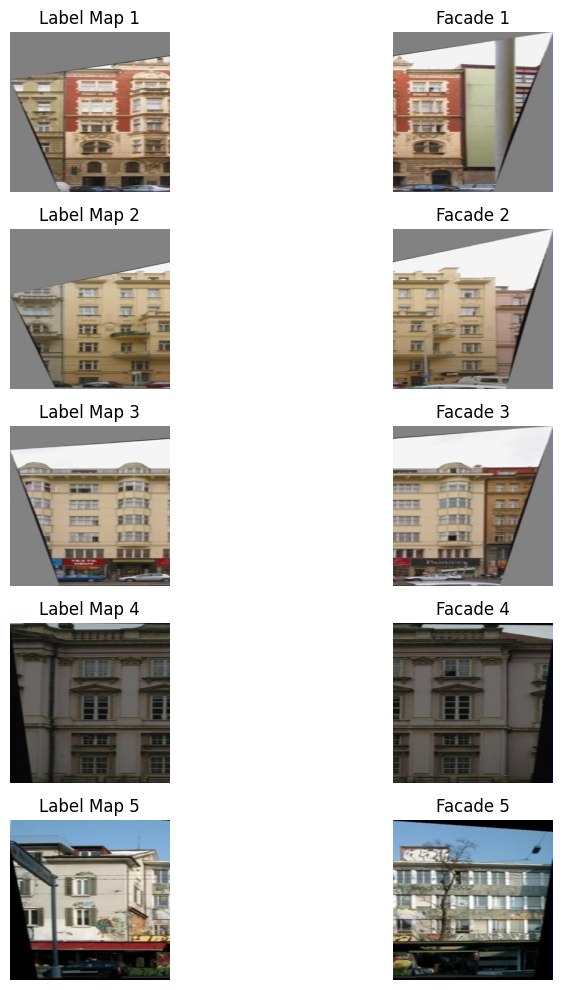

In [12]:
import matplotlib.pyplot as plt

# Number of samples to display
num_samples = 5

plt.figure(figsize=(10, 2 * num_samples))

for i in range(num_samples):
    input_img, real_img = dataset[i]  # Get the i-th sample

    # Convert tensors to images
    input_img = input_img.permute(1, 2, 0).numpy()
    real_img = real_img.permute(1, 2, 0).numpy()

    # Plot input label map
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow((input_img + 1) / 2)  # Undo normalization
    plt.axis("off")
    plt.title(f"Label Map {i+1}")

    # Plot corresponding real facade image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow((real_img + 1) / 2)  # Undo normalization
    plt.axis("off")
    plt.title(f"Facade {i+1}")

plt.tight_layout()
plt.show()


**Build the Generator (U-Net)**

In [6]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def conv_block(in_channels, out_channels, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        def deconv_block(in_channels, out_channels, dropout=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        # Encoder (Downsampling)
        self.enc1 = conv_block(3, 64, batch_norm=False)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        # Decoder (Upsampling)
        self.dec4 = deconv_block(512, 256)
        self.dec3 = deconv_block(256, 128)
        self.dec2 = deconv_block(128, 64)
        self.dec1 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d4 = self.dec4(e4)
        d3 = self.dec3(d4)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)

        return torch.tanh(d1)


**Build the Discriminator (PatchGAN)**

In [7]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))


**Define Loss and Optimizers**

In [27]:
adversarial_loss = nn.BCEWithLogitsLoss()  # More stable
l1_loss = nn.L1Loss()

generator = UNetGenerator()
discriminator = PatchGANDiscriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Add learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.5)


**Training the Model**

In [31]:
import torch.nn.functional as F

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

# Optimizers with Lower Learning Rate
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

# Learning Rate Scheduler (Reduce LR on Plateau)
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=3, verbose=True)
scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=3, verbose=True)

# Loss Tracking
loss_history = {'G_Loss': [], 'D_Loss': []}

for epoch in range(num_epochs):
    loop = tqdm(dataloader, leave=True)

    total_g_loss = 0  # Total generator loss
    total_d_loss = 0  # Total discriminator loss
    num_batches = len(dataloader)

    for i, (input_img, real_img) in enumerate(loop):
        input_img, real_img = input_img.to(device), real_img.to(device)

        ###### Train Discriminator ######
        optimizer_D.zero_grad()

        # Add noise to real images to stabilize training
        real_img = real_img + 0.05 * torch.randn_like(real_img)

        # Discriminator loss
        real_pred = discriminator(input_img, real_img)
        fake_img = generator(input_img).detach()
        fake_pred = discriminator(input_img, fake_img)

        real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))  # No smoothing
        fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()

        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer_D.step()

        ###### Train Generator ######
        optimizer_G.zero_grad()
        fake_img = generator(input_img)
        fake_pred = discriminator(input_img, fake_img)

        # Use Soft Labels (0.9 instead of 1)
        g_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred) * 0.9) + 50 * l1_loss(fake_img, real_img)
        g_loss.backward()

        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer_G.step()

        # Accumulate Loss
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        # Update tqdm progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(G_Loss=g_loss.item(), D_Loss=d_loss.item())

    # Average Loss Calculation
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss = total_d_loss / num_batches

    # Store Loss History
    loss_history['G_Loss'].append(avg_g_loss)
    loss_history['D_Loss'].append(avg_d_loss)

    # Learning Rate Adjustment
    scheduler_G.step(avg_g_loss)
    scheduler_D.step(avg_d_loss)

    # Print Loss Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg G_Loss: {avg_g_loss:.4f}, Avg D_Loss: {avg_d_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch [1/50]: 100%|██████████| 1012/1012 [00:31<00:00, 31.88it/s, D_Loss=0.591, G_Loss=15.8]


Epoch [1/50] - Avg G_Loss: 19.9568, Avg D_Loss: 0.5879


Epoch [2/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.94it/s, D_Loss=0.538, G_Loss=17.3]


Epoch [2/50] - Avg G_Loss: 18.6284, Avg D_Loss: 0.5598


Epoch [3/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.16it/s, D_Loss=0.505, G_Loss=27.1]


Epoch [3/50] - Avg G_Loss: 18.2158, Avg D_Loss: 0.5382


Epoch [4/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.72it/s, D_Loss=0.505, G_Loss=12.2]


Epoch [4/50] - Avg G_Loss: 17.8966, Avg D_Loss: 0.5105


Epoch [5/50]: 100%|██████████| 1012/1012 [00:31<00:00, 32.44it/s, D_Loss=0.505, G_Loss=13.5]


Epoch [5/50] - Avg G_Loss: 17.5981, Avg D_Loss: 0.5083


Epoch [6/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.08it/s, D_Loss=0.504, G_Loss=16.7]


Epoch [6/50] - Avg G_Loss: 17.3303, Avg D_Loss: 0.5070


Epoch [7/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.95it/s, D_Loss=0.503, G_Loss=16.8]


Epoch [7/50] - Avg G_Loss: 17.0912, Avg D_Loss: 0.5082


Epoch [8/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.23it/s, D_Loss=0.509, G_Loss=14.1]


Epoch [8/50] - Avg G_Loss: 16.8349, Avg D_Loss: 0.5065


Epoch [9/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.92it/s, D_Loss=0.512, G_Loss=21.5]


Epoch [9/50] - Avg G_Loss: 16.5881, Avg D_Loss: 0.5058


Epoch [10/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.00it/s, D_Loss=0.503, G_Loss=19.3]


Epoch [10/50] - Avg G_Loss: 16.3470, Avg D_Loss: 0.5061


Epoch [11/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.10it/s, D_Loss=0.503, G_Loss=16.4]


Epoch [11/50] - Avg G_Loss: 16.0840, Avg D_Loss: 0.5052


Epoch [12/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.89it/s, D_Loss=0.503, G_Loss=12.7]


Epoch [12/50] - Avg G_Loss: 15.7980, Avg D_Loss: 0.5050


Epoch [13/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.70it/s, D_Loss=0.503, G_Loss=16.9]


Epoch [13/50] - Avg G_Loss: 15.5341, Avg D_Loss: 0.5049


Epoch [14/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.69it/s, D_Loss=0.503, G_Loss=17.7]


Epoch [14/50] - Avg G_Loss: 15.2341, Avg D_Loss: 0.5048


Epoch [15/50]: 100%|██████████| 1012/1012 [00:31<00:00, 32.56it/s, D_Loss=0.503, G_Loss=12.1]


Epoch [15/50] - Avg G_Loss: 14.9243, Avg D_Loss: 0.5054


Epoch [16/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.04it/s, D_Loss=0.503, G_Loss=21]


Epoch [16/50] - Avg G_Loss: 14.6503, Avg D_Loss: 0.5047


Epoch [17/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.10it/s, D_Loss=0.503, G_Loss=15.9]


Epoch [17/50] - Avg G_Loss: 14.3311, Avg D_Loss: 0.5054


Epoch [18/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.18it/s, D_Loss=0.503, G_Loss=15.9]


Epoch [18/50] - Avg G_Loss: 14.0180, Avg D_Loss: 0.5047


Epoch [19/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.94it/s, D_Loss=0.503, G_Loss=13.2]


Epoch [19/50] - Avg G_Loss: 13.7717, Avg D_Loss: 0.5047


Epoch [20/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.15it/s, D_Loss=0.503, G_Loss=16.7]


Epoch [20/50] - Avg G_Loss: 13.4869, Avg D_Loss: 0.5056


Epoch [21/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.85it/s, D_Loss=0.503, G_Loss=10.7]


Epoch [21/50] - Avg G_Loss: 13.2286, Avg D_Loss: 0.5037


Epoch [22/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.20it/s, D_Loss=0.503, G_Loss=12.3]


Epoch [22/50] - Avg G_Loss: 12.9819, Avg D_Loss: 0.5041


Epoch [23/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.00it/s, D_Loss=0.503, G_Loss=10.1]


Epoch [23/50] - Avg G_Loss: 12.7410, Avg D_Loss: 0.5034


Epoch [24/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.27it/s, D_Loss=0.503, G_Loss=11.8]


Epoch [24/50] - Avg G_Loss: 12.4826, Avg D_Loss: 0.5051


Epoch [25/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.66it/s, D_Loss=0.503, G_Loss=13.4]


Epoch [25/50] - Avg G_Loss: 12.2620, Avg D_Loss: 0.5037


Epoch [26/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.88it/s, D_Loss=0.503, G_Loss=11.3]


Epoch [26/50] - Avg G_Loss: 12.0438, Avg D_Loss: 0.5039


Epoch [27/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.78it/s, D_Loss=0.503, G_Loss=8.25]


Epoch [27/50] - Avg G_Loss: 11.8403, Avg D_Loss: 0.5037


Epoch [28/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.03it/s, D_Loss=0.503, G_Loss=10.6]


Epoch [28/50] - Avg G_Loss: 11.6639, Avg D_Loss: 0.5033


Epoch [29/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.00it/s, D_Loss=0.503, G_Loss=12.6]


Epoch [29/50] - Avg G_Loss: 11.4591, Avg D_Loss: 0.5034


Epoch [30/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.26it/s, D_Loss=0.507, G_Loss=9.52]


Epoch [30/50] - Avg G_Loss: 11.2748, Avg D_Loss: 0.5035


Epoch [31/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.03it/s, D_Loss=0.503, G_Loss=13]


Epoch [31/50] - Avg G_Loss: 11.1015, Avg D_Loss: 0.5034


Epoch [32/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.13it/s, D_Loss=0.504, G_Loss=9.28]


Epoch [32/50] - Avg G_Loss: 10.9335, Avg D_Loss: 0.5033


Epoch [33/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.98it/s, D_Loss=0.503, G_Loss=7.82]


Epoch [33/50] - Avg G_Loss: 10.7715, Avg D_Loss: 0.5033


Epoch [34/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.15it/s, D_Loss=0.503, G_Loss=9.82]


Epoch [34/50] - Avg G_Loss: 10.6220, Avg D_Loss: 0.5033


Epoch [35/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.97it/s, D_Loss=0.503, G_Loss=11.3]


Epoch [35/50] - Avg G_Loss: 10.4931, Avg D_Loss: 0.5035


Epoch [36/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.76it/s, D_Loss=0.503, G_Loss=10.1]


Epoch [36/50] - Avg G_Loss: 10.3284, Avg D_Loss: 0.5033


Epoch [37/50]: 100%|██████████| 1012/1012 [00:31<00:00, 32.49it/s, D_Loss=0.503, G_Loss=9.18]


Epoch [37/50] - Avg G_Loss: 10.1920, Avg D_Loss: 0.5034


Epoch [38/50]: 100%|██████████| 1012/1012 [00:31<00:00, 32.63it/s, D_Loss=0.503, G_Loss=8.22]


Epoch [38/50] - Avg G_Loss: 10.0512, Avg D_Loss: 0.5033


Epoch [39/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.68it/s, D_Loss=0.503, G_Loss=9.77]


Epoch [39/50] - Avg G_Loss: 9.9179, Avg D_Loss: 0.5034


Epoch [40/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.05it/s, D_Loss=0.503, G_Loss=12.4]


Epoch [40/50] - Avg G_Loss: 9.8161, Avg D_Loss: 0.5033


Epoch [41/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.04it/s, D_Loss=0.503, G_Loss=7.87]


Epoch [41/50] - Avg G_Loss: 9.6912, Avg D_Loss: 0.5033


Epoch [42/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.05it/s, D_Loss=0.503, G_Loss=12.5]


Epoch [42/50] - Avg G_Loss: 9.5659, Avg D_Loss: 0.5033


Epoch [43/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.94it/s, D_Loss=0.503, G_Loss=7.82]


Epoch [43/50] - Avg G_Loss: 9.4657, Avg D_Loss: 0.5033


Epoch [44/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.73it/s, D_Loss=0.503, G_Loss=10.6]


Epoch [44/50] - Avg G_Loss: 9.3661, Avg D_Loss: 0.5032


Epoch [45/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.97it/s, D_Loss=0.503, G_Loss=9.44]


Epoch [45/50] - Avg G_Loss: 9.2583, Avg D_Loss: 0.5033


Epoch [46/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.94it/s, D_Loss=0.503, G_Loss=6.77]


Epoch [46/50] - Avg G_Loss: 9.1599, Avg D_Loss: 0.5032


Epoch [47/50]: 100%|██████████| 1012/1012 [00:30<00:00, 33.04it/s, D_Loss=0.503, G_Loss=8.06]


Epoch [47/50] - Avg G_Loss: 9.0627, Avg D_Loss: 0.5032


Epoch [48/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.88it/s, D_Loss=0.503, G_Loss=9.89]


Epoch [48/50] - Avg G_Loss: 8.9709, Avg D_Loss: 0.5036


Epoch [49/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.89it/s, D_Loss=0.503, G_Loss=8.72]


Epoch [49/50] - Avg G_Loss: 8.8738, Avg D_Loss: 0.5036


Epoch [50/50]: 100%|██████████| 1012/1012 [00:30<00:00, 32.93it/s, D_Loss=0.503, G_Loss=10.2]

Epoch [50/50] - Avg G_Loss: 8.7915, Avg D_Loss: 0.5036


**Save Model and Generate Images**

In [33]:
torch.save(generator.state_dict(), "pix2pix_generator.pth")
torch.save(discriminator.state_dict(), "pix2pix_discriminator.pth")


In [38]:
# Load trained generator
generator = UNetGenerator()
generator.load_state_dict(torch.load("pix2pix_generator.pth"))
generator.to(device)
generator.eval()  # Set to evaluation mode


UNetGenerator(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (dec4): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, e

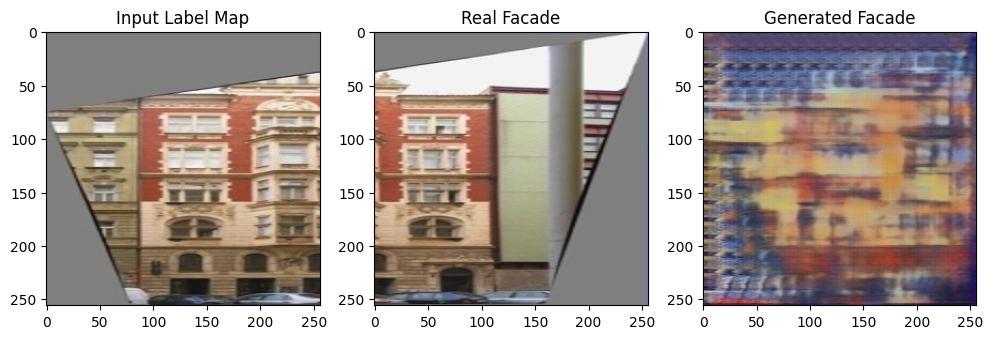

In [39]:
import matplotlib.pyplot as plt

def generate_facade(generator, input_img):
    input_img = input_img.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        fake_img = generator(input_img).cpu().squeeze(0)  # Remove batch dimension
    return fake_img

# Select a test sample
input_img, real_img = dataset[0]  # Load a test example
fake_img = generate_facade(generator, input_img)

# Convert tensors to images for visualization
input_img = input_img.permute(1, 2, 0).cpu().numpy()
real_img = real_img.permute(1, 2, 0).cpu().numpy()
fake_img = fake_img.permute(1, 2, 0).numpy()

# Display input, real, and generated images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow((input_img + 1) / 2)  # Normalize back
plt.title("Input Label Map")

plt.subplot(1, 3, 2)
plt.imshow((real_img + 1) / 2)
plt.title("Real Facade")

plt.subplot(1, 3, 3)
plt.imshow((fake_img + 1) / 2)
plt.title("Generated Facade")

plt.show()


In [49]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Convert images to NumPy arrays for evaluation
real_img_np = (real_img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
fake_img_np = (fake_img + 1) / 2

# Explicitly set win_size to a smaller odd value
win_size = 3  # For example, using a 3x3 window

# Compute SSIM with the specified win_size and data_range
ssim_value = ssim(real_img_np, fake_img_np, win_size=win_size, multichannel=True, data_range=1.0)  # Specify data_range=1.0
print(f"SSIM: {ssim_value:.4f}")

SSIM: 0.2748
